In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time

from src.underlying_dynamics import (
    simulate_GBM_dynamics,
    price_grid_from_samples,
    discrete_probs_from_samples,
    build_joint_target_from_P_bin
)
from src.training_utils import minimize_with_cost_history
from src.plotting_utilities import(
    plot_GBM_dynamics,
    plot_histogram_comparison,
    plot_training_diagnostics
)
from src.multi_layer_QCBM import MLQcbmCircuit

from scipy.optimize import minimize
from qiskit_algorithms.optimizers import SPSA

## Loading target probability distribution $p_{tg}(x)$ (clasically computed)

In [2]:
# Discretization parameters
n = 2
m = 2
N = 2**n  # number of price bins
M = 2**m  # number of time steps

In [3]:
# ============================================================
# 0) Reproducibility
# ============================================================
np.random.seed(123)
 
# ============================================================
# 1) Simulate S(t) paths
# ============================================================

# Simulation parameters
S0 = 5.0
K = 5.5
sigma = 0.25
r = 0.02

# Fine time grid
T = 1
N_paths = 100_000
t = np.linspace(0.0, T, M+1)

# Simulate paths
n_paths = 10000
Z = np.random.standard_normal(size=(n_paths, M))

S_by_time = simulate_GBM_dynamics(S0=S0, mu=r, sigma=sigma, t=t, Z=Z)

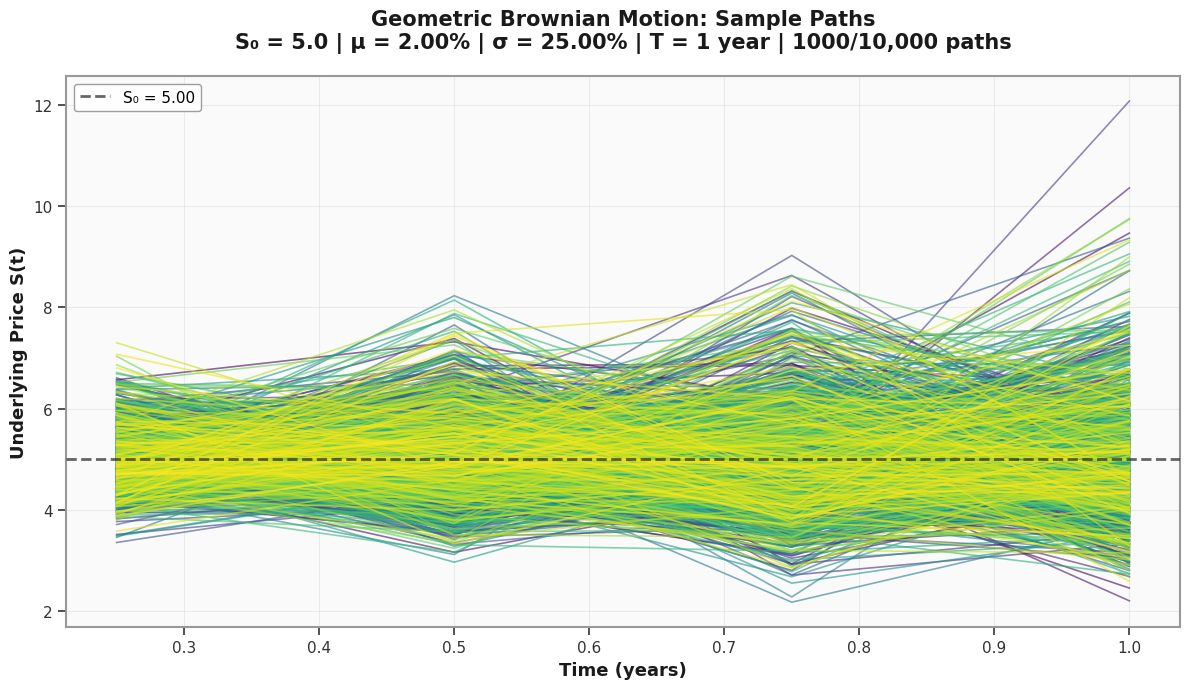

In [4]:
fig, ax = plot_GBM_dynamics(
    S_by_time, t, S0, r, sigma, T, n_paths, n_plot=1000
)
plt.show()

In [5]:
# ============================================================
# 2) Discretize prices: choose n so that N=2^n bins (power of two)
# ============================================================
n_sigma = 3.0

edges, s_mid = price_grid_from_samples(S_by_time, n=n, n_sigma=n_sigma)
grid_info = {'s_mid': s_mid}
print("Grid info:", grid_info)
print("edges length:", len(edges), "=> N bins:", len(edges) - 1)
assert (len(edges) - 1) == N

Grid info: {'s_mid': array([2.18201879, 4.13489507, 6.08777135, 8.04064763])}
edges length: 5 => N bins: 4


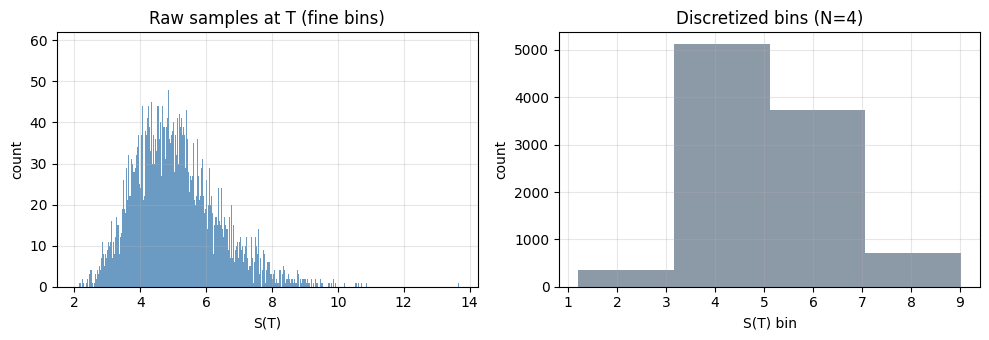

In [6]:
# ============================================================
# 2b) Histogram: raw vs discretized prices (loss of resolution)
# ============================================================
# Samples at final time
samples_hr_final = S_by_time[-1]
fig, axes = plot_histogram_comparison(samples_hr_final, edges)
plt.show()

In [7]:
# ============================================================
# 3) Build conditional distributions P_bin[i,:] = P(s_bin | t_i)
# ============================================================
P_bin = np.zeros((M, N), dtype=float) 
for i in range(M):
    P_bin[i, :] = discrete_probs_from_samples(S_by_time[i], edges)

assert P_bin.shape == (M, N)
assert np.all(P_bin >= -1e-15)
assert np.allclose(P_bin.sum(axis=1), 1.0, atol=1e-10)
print("P_bin OK. shape:", P_bin.shape)

P_bin OK. shape: (4, 4)


In [8]:
# ============================================================
# 4) Build joint target for QCBM 
#    p_tg(i,j) = P(t_i) P(s_j|t_i), with uniform P(t_i)=1/M by default
# ============================================================
tgt = build_joint_target_from_P_bin(P_bin, order="time_major") 

print("\n--- Joint target summary ---")
print(f"M={tgt.M} (m={tgt.m} qubits), N={tgt.N} (n={tgt.n} qubits)")
print("len(p_tg) =", tgt.p_tg.size, "(expected M*N =", tgt.M * tgt.N, ")")
print("sum(p_tg) =", tgt.p_tg.sum())

assert tgt.M == M
assert tgt.N == N
assert tgt.p_tg.ndim == 1
assert tgt.p_tg.size == M * N
assert abs(tgt.p_tg.sum() - 1.0) < 1e-12


--- Joint target summary ---
M=4 (m=2 qubits), N=4 (n=2 qubits)
len(p_tg) = 16 (expected M*N = 16 )
sum(p_tg) = 1.0


Joint target distribution:
$$
p_{tg}(x),
$$
a flatten vector with $2^{n + m}$ elements. So the register $x$ is written in the computational basis of $n + m$ qubits.

In [9]:
# ============================================================
# Print all computational basis states directly from p_tg
# ============================================================
# Sanity check: check dimensions of tgt are correct
ptg = tgt.p_tg
m = tgt.m      # time qubits
n = tgt.n      # price qubits
M = tgt.M
N = tgt.N

def to_bits(x, L):
    return format(x, f"0{L}b")

print("Probability distribution over computational basis states (quantum - friendly):")

for x, prob in enumerate(ptg):
    # Binary representation of the full register
    bits = to_bits(x, m + n)

    # Decode indices according to time_major convention
    i = x // N          # time index
    j = x % N           # price-bin index

    bits_time  = bits[:m]
    bits_price = bits[m:]

    print(
        f"|{bits}>  "
        f"(t_{i+1}, s_{j})  "
        f"P = {prob:.6e}"
    )


Probability distribution over computational basis states (quantum - friendly):
|0000>  (t_1, s_0)  P = 2.500000e-05
|0001>  (t_1, s_1)  P = 1.437250e-01
|0010>  (t_1, s_2)  P = 1.055500e-01
|0011>  (t_1, s_3)  P = 7.000000e-04
|0100>  (t_2, s_0)  P = 1.275638e-03
|0101>  (t_2, s_1)  P = 1.390945e-01
|0110>  (t_2, s_2)  P = 1.042521e-01
|0111>  (t_2, s_3)  P = 5.377689e-03
|1000>  (t_3, s_0)  P = 4.537251e-03
|1001>  (t_3, s_1)  P = 1.334353e-01
|1010>  (t_3, s_2)  P = 9.976938e-02
|1011>  (t_3, s_3)  P = 1.225810e-02
|1100>  (t_4, s_0)  P = 8.903349e-03
|1101>  (t_4, s_1)  P = 1.290355e-01
|1110>  (t_4, s_2)  P = 9.417877e-02
|1111>  (t_4, s_3)  P = 1.788236e-02


---

## QCBM ansatz definition & training

In [10]:
# Rename discretization variables to enhance quantum readability
num_qubits_price = n
num_qubits_time = m
num_qubits = num_qubits_price + num_qubits_time

In [11]:
# Ansatz definition
EPS_COST = 1e-12

qcbm = MLQcbmCircuit(n_qubits=num_qubits, n_layers=2, name="G_p")  
qc, theta = qcbm.qc, qcbm.theta

print(qc.draw(output="text", fold=120))
print("n_layers:", qcbm.n_layers)
print("n_params:", qcbm.n_params)


     ┌──────────────┐┌──────────────┐┌────────────────┐┌────────────────┐┌─────────────────┐                   »
q_0: ┤ Rx(theta[0]) ├┤ Rz(theta[1]) ├┤0               ├┤0               ├┤0                ├───────────────────»
     ├──────────────┤├──────────────┤│  Rxx(theta[8]) ││                ││                 │┌─────────────────┐»
q_1: ┤ Rx(theta[2]) ├┤ Rz(theta[3]) ├┤1               ├┤  Rxx(theta[9]) ├┤                 ├┤0                ├»
     ├──────────────┤├──────────────┤└────────────────┘│                ││  Rxx(theta[10]) ││  Rxx(theta[11]) │»
q_2: ┤ Rx(theta[4]) ├┤ Rz(theta[5]) ├──────────────────┤1               ├┤                 ├┤1                ├»
     ├──────────────┤├──────────────┤                  └────────────────┘│                 │└─────────────────┘»
q_3: ┤ Rx(theta[6]) ├┤ Rz(theta[7]) ├────────────────────────────────────┤1                ├───────────────────»
     └──────────────┘└──────────────┘                                    └─────────────────┘    

### Ideal Probability Evaluation vs. Shot-Based Estimation

In variational quantum algorithms such as Quantum Circuit Born Machines (QCBMs), the model distribution is defined by the Born probabilities of a parameterized quantum circuit. There are two conceptually distinct ways of accessing these probabilities: the *ideal (statevector)* evaluation and the *shot-based* estimation. Although both originate from the same underlying quantum state, they differ fundamentally in how probabilities are obtained and in the presence of statistical noise.


<br>


In the **ideal *(statevector)* setting**, the parameterized circuit $U(\theta)$ is applied to the computational basis state $|0\cdots 0\rangle$, and the full quantum state is computed exactly:
$$
|\psi(\theta)\rangle = U(\theta)\,|0\cdots 0\rangle
= \sum_{x \in \{0,1\}^n} a_x(\theta)\,|x\rangle .
$$

All complex amplitudes $a_x(\theta)$ are explicitly available. The model probabilities are then obtained deterministically as

$$
\boxed{
p_\theta(x) = |a_x(\theta)|^2 \quad \text{for all } x .
}
$$


This procedure involves no sampling and no measurement. The resulting probability vector is exact, the loss function is deterministic, and repeated evaluations at the same parameters $\theta$ always return the same value. This regime is accessible only in classical simulation and serves as an idealized reference for analysis and debugging.


<br>

In contrast, while working in a ***shot-based* setting**, the circuit is followed by measurements in the computational basis. Each execution (shot) produces a single bitstring outcome
$$
X \in \{0,1\}^n,
$$
distributed according to the Born rule:
$$
\mathbb{P}(X = x) = |a_x(\theta)|^2 .
$$

Repeating the experiment $N_{\text{shots}}$ times yields independent and identically distributed samples $X_1, \dots, X_{N_{\text{shots}}}$. The probabilities are then estimated empirically via relative frequencies,

$$
\boxed{
\hat p_\theta(x) = \frac{1}{N_{\text{shots}}}
\sum_{k=1}^{N_{\text{shots}}} \mathbf{1}_{\{X_k = x\}} .
}
$$

The resulting estimator is unbiased,
$$
\mathbb{E}[\hat p_\theta(x)] = p_\theta(x),
$$
but exhibits statistical fluctuations with variance
$$
\mathrm{Var}[\hat p_\theta(x)] =
\frac{p_\theta(x)\bigl(1 - p_\theta(x)\bigr)}{N_{\text{shots}}}.
$$

Consequently, any cost function built from $\hat p_\theta$ is inherently noisy, and its evaluation varies from call to call even at fixed parameters.

In the limit $N_{\text{shots}} \to \infty$, the shot-based estimator converges to the ideal probabilities, but for any finite number of shots, statistical noise is unavoidable. This difference has direct consequences for optimization, as noise-free objective functions are fundamentally easier to minimize than their stochastic counterparts.

## 1. Estimation under the ideal (*statevector*) setting.

Hyperparameters of the training

In [12]:
# ---- fixed hyperparams / reproducibility ----
SEED = 123
N_ITERS = 7000
RHOBEG = 1.0
METHOD = "COBYLA"

rng = np.random.default_rng(SEED)
x0 = rng.standard_normal(len(theta)).astype(float)

Optimization (Training) of the quantum circuit

In [13]:
# Define cost function
cost = qcbm.cost_fn(ptg, eps=EPS_COST)

# -------------------------
# Start timing
# -------------------------
t_start = time.time()

# Run the optimization
res, cost_history = minimize_with_cost_history(
    cost,
    x0=x0,
    minimize_fn=minimize,
    method=METHOD,
    options={"maxiter": int(N_ITERS), 
             "rhobeg": RHOBEG,
             "disp": True},
)

t_end = time.time()
training_time = t_end - t_start
# -------------------------

theta_star = np.asarray(res.x, dtype=float)

# ------ Probabilities: p0 -> before training, p_star -> after training ------ 
p0 = qcbm.probabilities(x0)
p_star = qcbm.probabilities(theta_star)
# ----------------------------------------------------------------------------

print("success:", res.success)
print("message:", res.message)
print("nfev:", getattr(res, "nfev", None), "nit:", getattr(res, "nit", None))
print("final cost:", float(res.fun))

success: False
message: Maximum number of function evaluations has been exceeded.
nfev: 7000 nit: None
final cost: 2.2463148575242413


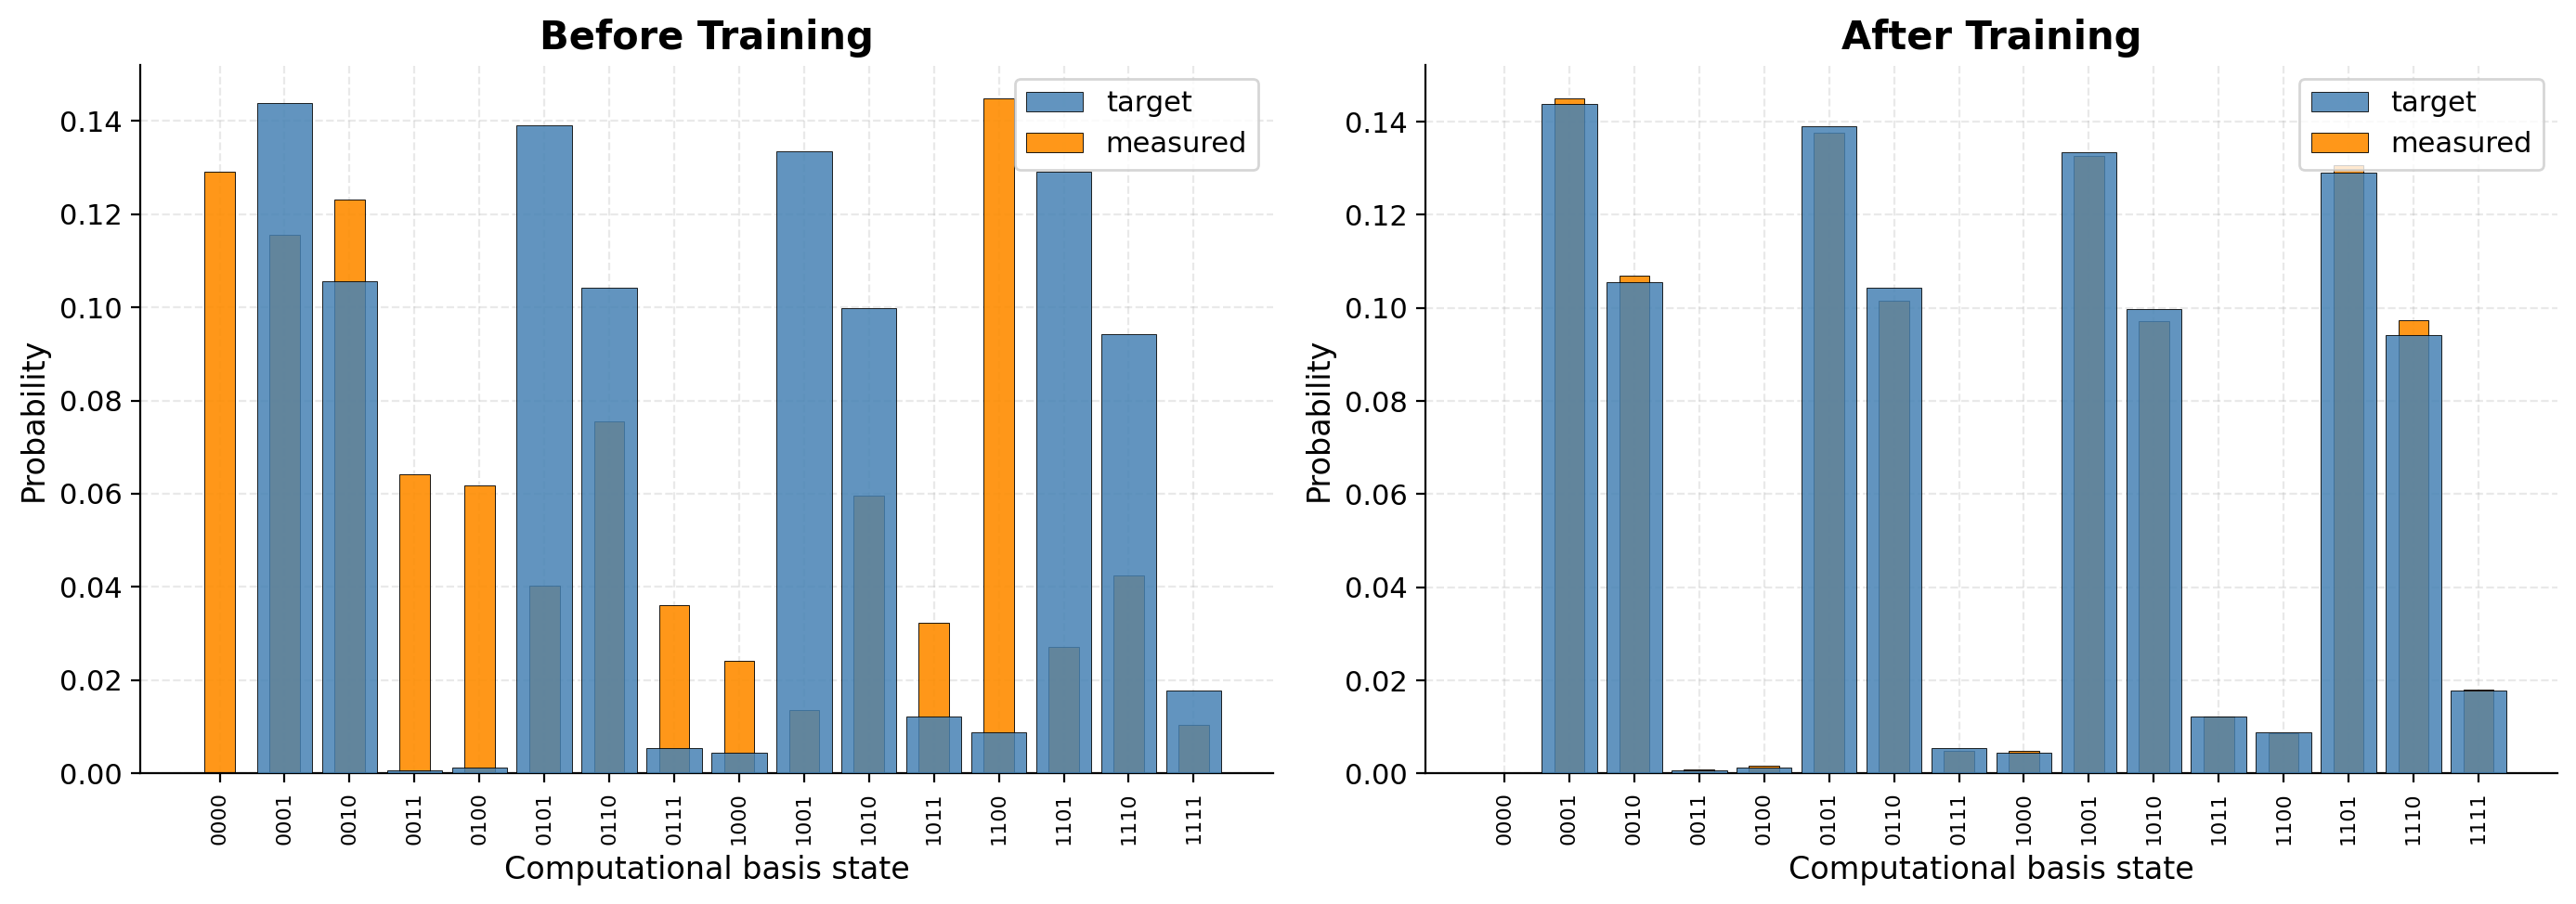

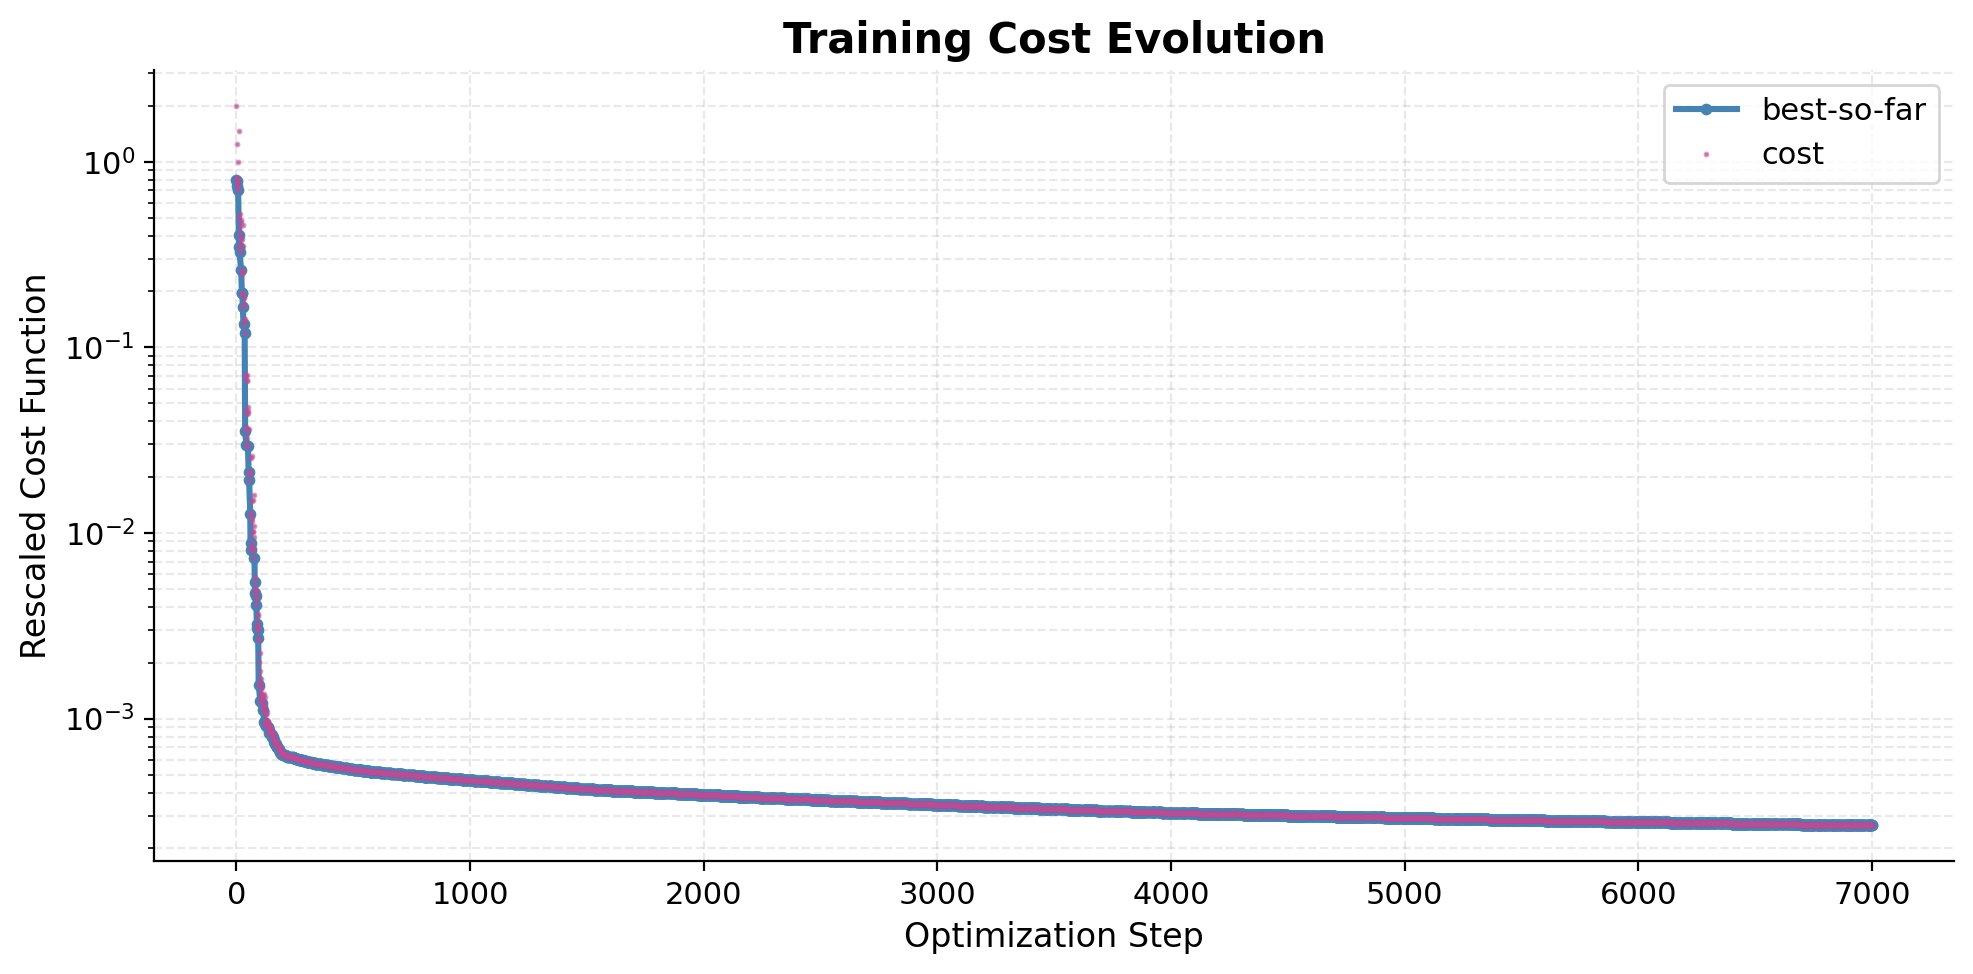


=== 'FIT' METRIC + OTHERS ===
Training time: 5.42s (0.09 min)
KL(ptg || p*)  = 0.0002658516525433857
L1             = 0.01678936205739773
TV = 0.5*L1    = 0.008394681028698866
Linf           = 0.0031764456026210364

=== PROBABILITY VECTORS ===
Target (ptg):
[2.50000000e-05 1.43725000e-01 1.05550000e-01 7.00000000e-04
 1.27563782e-03 1.39094547e-01 1.04252126e-01 5.37768884e-03
 4.53725058e-03 1.33435275e-01 9.97693773e-02 1.22580969e-02
 8.90334948e-03 1.29035513e-01 9.41787732e-02 1.78823648e-02]

Learned (p_star):
[3.19612076e-05 1.45006376e-01 1.06939047e-01 8.44269387e-04
 1.65993167e-03 1.37660242e-01 1.01565717e-01 4.77659780e-03
 4.79896099e-03 1.32662750e-01 9.72254505e-02 1.21633454e-02
 8.64167695e-03 1.30668732e-01 9.73552188e-02 1.79997227e-02]


In [14]:
# --- Cost function rescaling: ideal value ~ 0 ---
C_star = -np.sum(ptg * np.log(np.maximum(ptg, EPS_COST)))
rescaled = cost_history - C_star
rescaled_plot = np.maximum(rescaled, 1e-12)          # for semilogy
best_so_far = np.minimum.accumulate(rescaled_plot)

tol = 1e-15
best_idx = np.flatnonzero(np.r_[True, best_so_far[1:] < best_so_far[:-1] - tol])

labels = [format(i, f"0{qcbm.n_qubits}b") for i in range(qcbm.dim)]

fig_dist, fig_cost = plot_training_diagnostics(
    target=ptg,
    before=p0,
    after=p_star,
    cost_history=rescaled_plot,
    best_so_far=best_so_far,
    best_idx=best_idx,
    labels=labels,  # Time+Price: use computational basis labels
)
plt.show()

ms = qcbm.metrics(ptg, p_star)

print("\n=== 'FIT' METRIC + OTHERS ===")
print(f"Training time: {training_time:.2f}s ({training_time/60:.2f} min)")
print("KL(ptg || p*)  =", float(ms["kl"]))
print("L1             =", float(ms["l1"]))
print("TV = 0.5*L1    =", float(ms["tv"]))
print("Linf           =", float(ms["linf"]))

print("\n=== PROBABILITY VECTORS ===")
print("Target (ptg):")
print(ptg)
print("\nLearned (p_star):")
print(p_star)

---

## 2. Shots based example

In [15]:
# -------------------------
# Fixed training budget
# -------------------------
N_ITERS = 3000
SHOTS   = 1000

# Use best params found by CV
best_lr = 0.006999999999999999
best_pert = 0.06999999999999999

LR   = float(best_lr)
PERT = float(best_pert)
eps = float(1e-15)

# -------------------------
# Cost function (shot-based)
# -------------------------
cost_shots = qcbm.cost_fn(
    ptg,
    eps=eps,
    shots=SHOTS,
    seed=None,
    rescaled=True,
    smoothing="dirichlet",
)

# -------------------------
# Plain SPSA run (store best theta)
# -------------------------
theta0 = np.asarray(x0, dtype=float).copy()

cost_history: list[float] = []
best = {"fx": float("inf"), "x": theta0.copy()}

def cb(nfev, x, fx, stepsize, accepted):
    fx = float(fx)
    cost_history.append(fx)
    if fx < best["fx"]:
        best["fx"] = fx
        best["x"] = np.asarray(x, dtype=float).copy()  

opt = SPSA(
    maxiter=int(N_ITERS),
    learning_rate=LR,
    perturbation=PERT,
    resamplings=1,
    blocking=False,
    callback=cb,
    regularization=0.5
)

# -------------------------
# Start timing
# -------------------------
t_start = time.time()

res = opt.minimize(fun=cost_shots, x0=theta0)

t_end = time.time()
training_time_shots = t_end - t_start
# -------------------------
 
theta_last = np.asarray(res.x, dtype=float)
theta_best = best["x"].copy()

print(f"Best cost: {best['fx']:.6e}")
ms_best = qcbm.metrics(ptg, qcbm.probabilities(theta_best))
print(f"Final KL: {ms_best['kl']:.6e}")

Best cost: 9.009263e-03
Final KL: 1.715548e-02


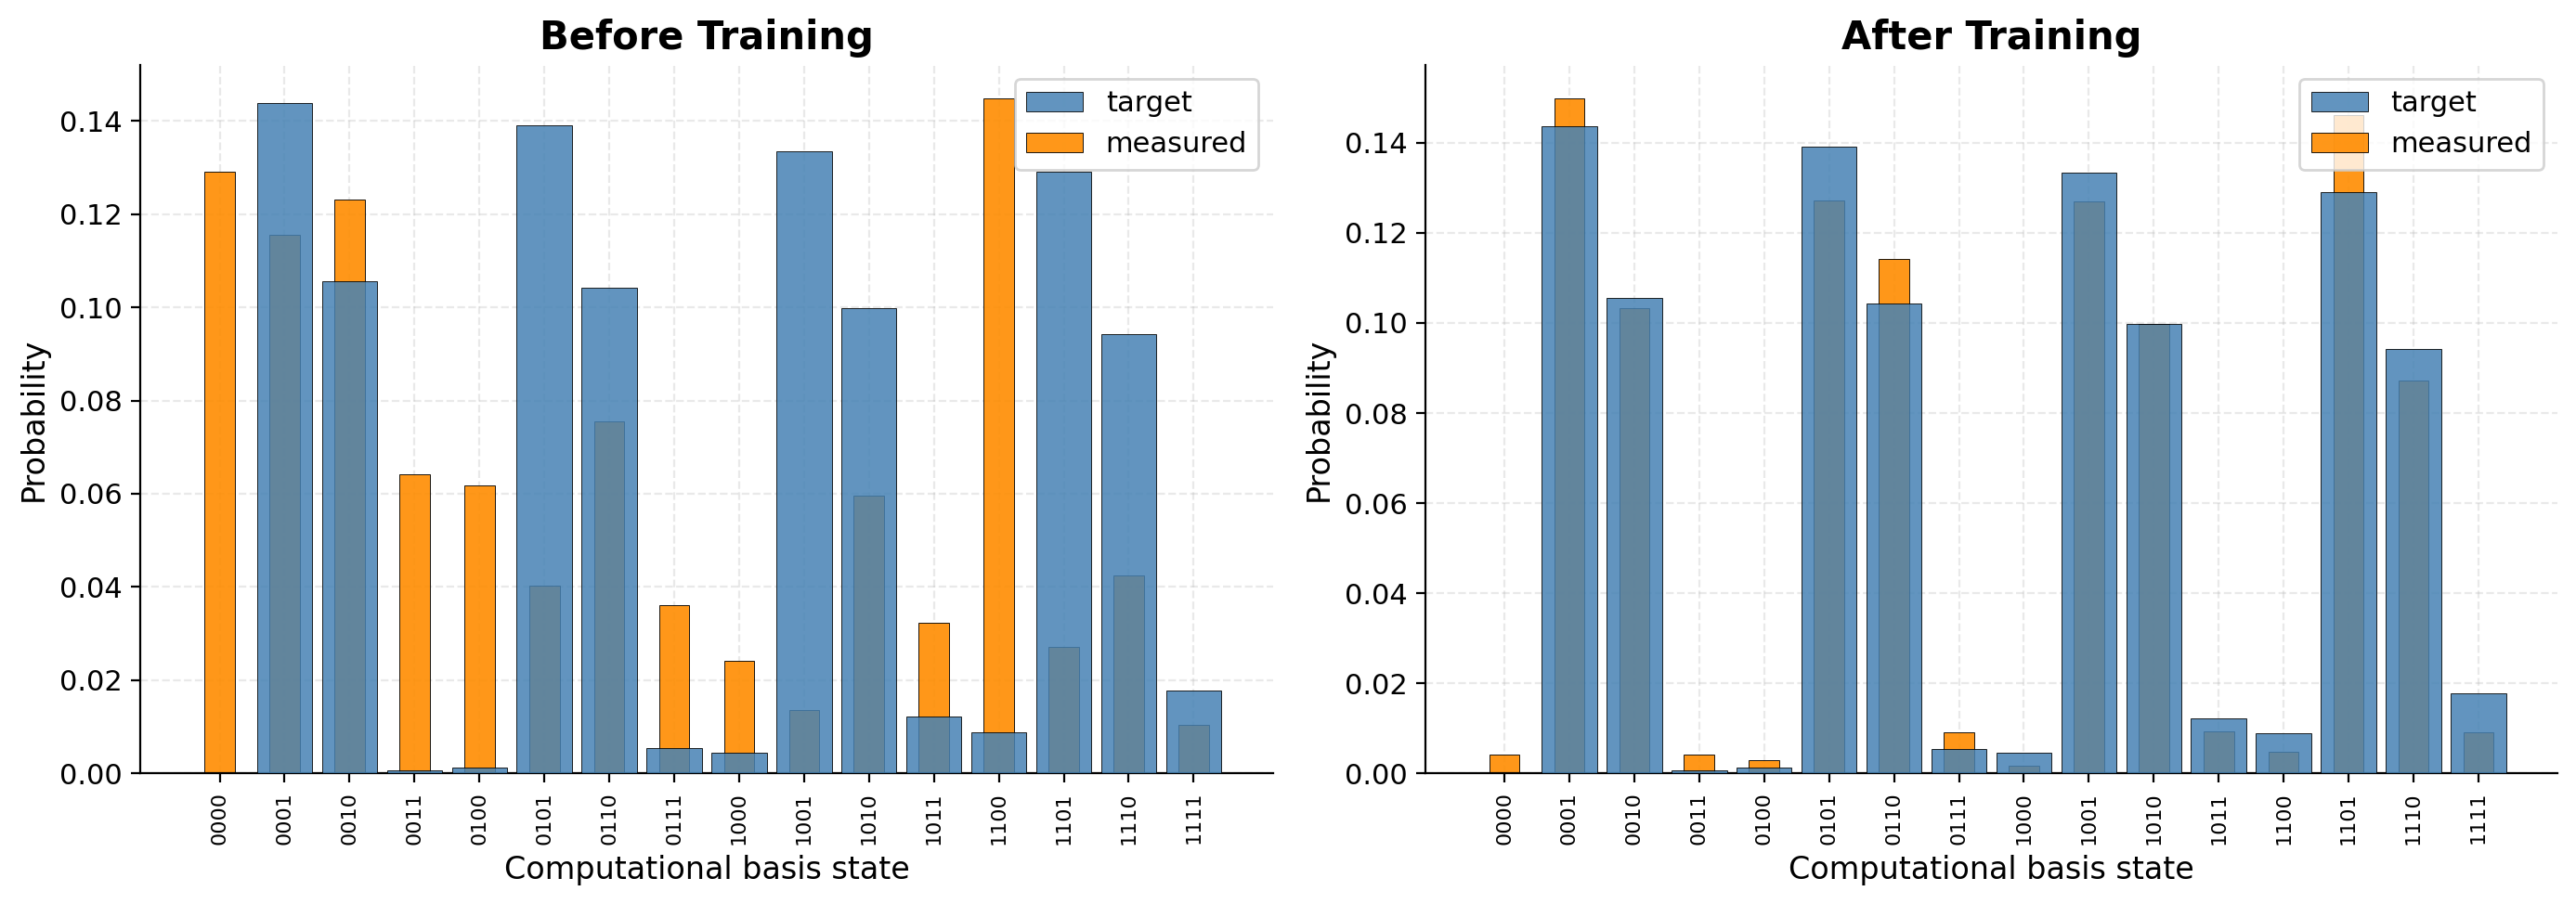

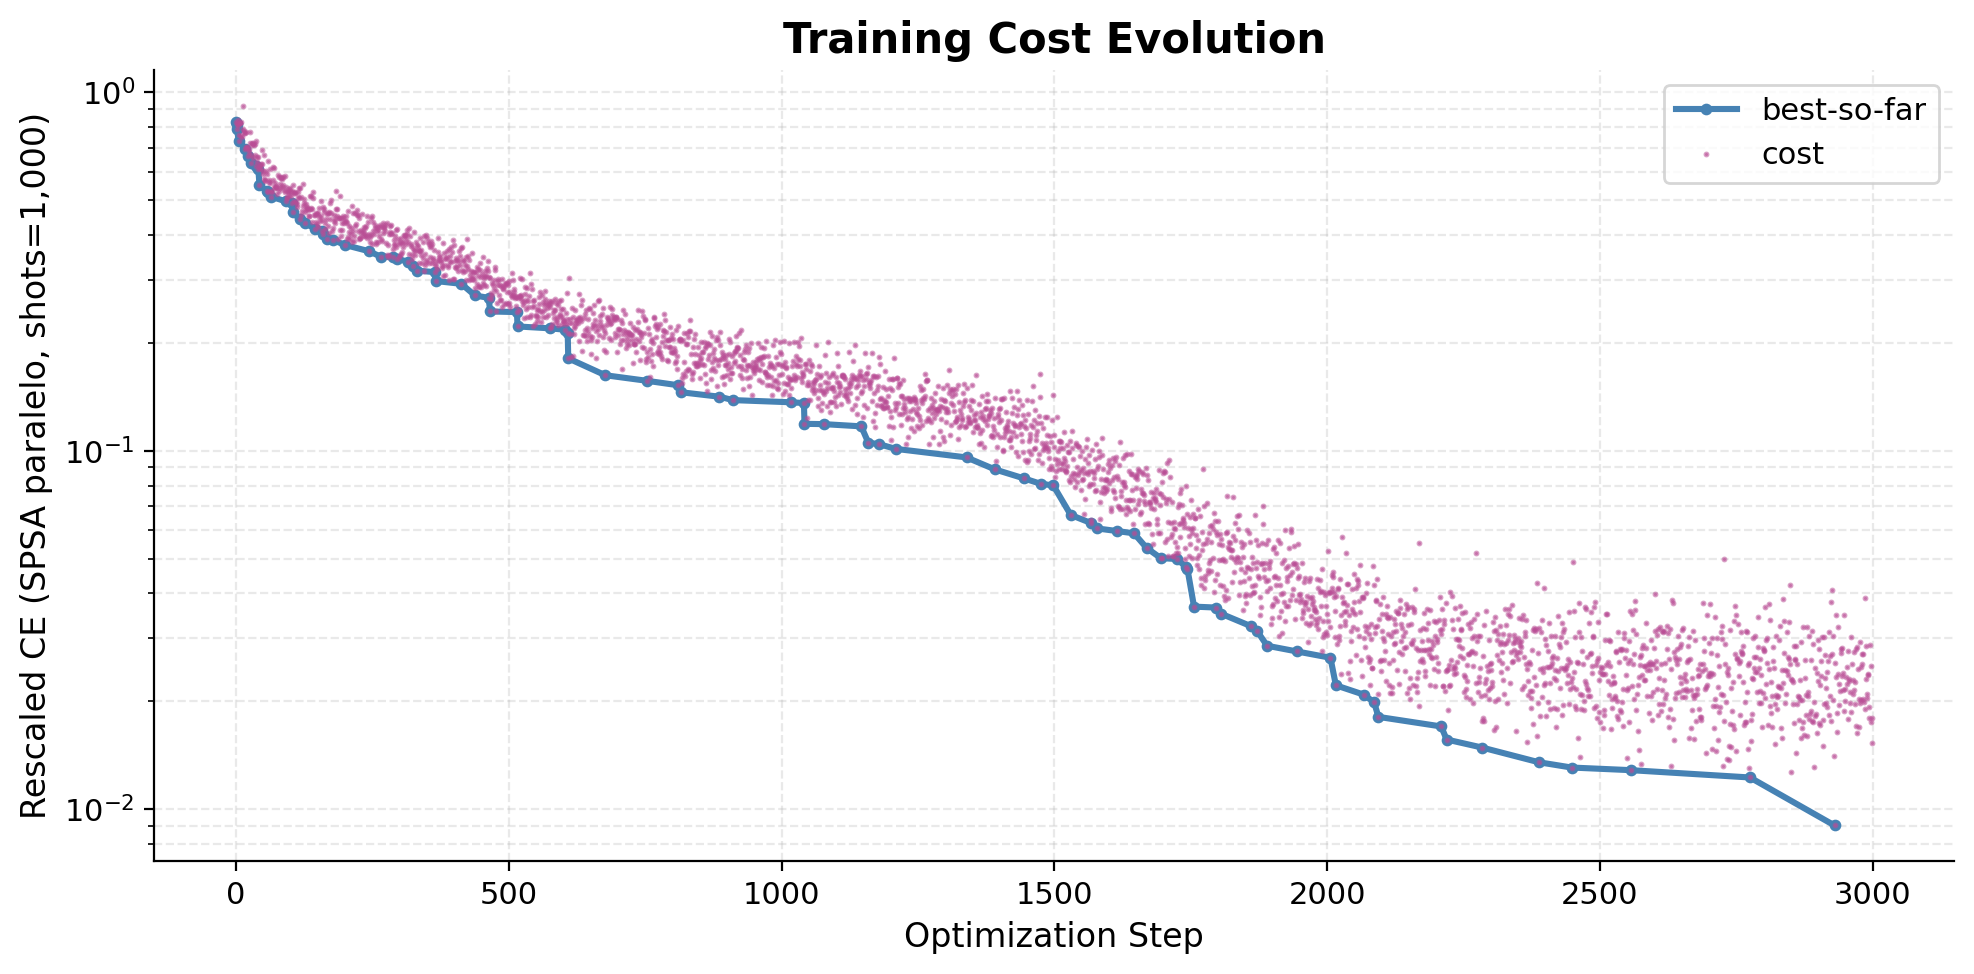


=== 'FIT' METRICS (SPSA with shots) ===
Training time: 24.99s (0.42 min)
KL(ptg || p*)  = 0.017155475142965528
L1             = 0.0926109646825855
TV = 0.5*L1    = 0.04630548234129275
Linf           = 0.017114841052597196

=== PROBABILITY VECTORS ===
Target (ptg):
[2.50000000e-05 1.43725000e-01 1.05550000e-01 7.00000000e-04
 1.27563782e-03 1.39094547e-01 1.04252126e-01 5.37768884e-03
 4.53725058e-03 1.33435275e-01 9.97693773e-02 1.22580969e-02
 8.90334948e-03 1.29035513e-01 9.41787732e-02 1.78823648e-02]

Learned (p_best_plot):
[0.00425077 0.14982426 0.10325298 0.00421001 0.00290689 0.12714287
 0.11411444 0.00923972 0.00169132 0.12700229 0.09976408 0.00929064
 0.0048241  0.14615035 0.08715231 0.00918296]


In [16]:
# -------------------------
# Diagnostics plot usando plot_training_diagnostics
# -------------------------
cost_shots_arr = np.asarray(cost_history, dtype=float)
cost_shots_plot = np.maximum(cost_shots_arr, 1e-12)
best_so_far_shots = np.minimum.accumulate(cost_shots_plot)

tol = 1e-15
best_idx_shots = np.flatnonzero(np.r_[True, best_so_far_shots[1:] < best_so_far_shots[:-1] - tol])

p0_plot = qcbm.probabilities(theta0)
p_best_plot = qcbm.probabilities(theta_best)

labels = [format(i, f"0{qcbm.n_qubits}b") for i in range(qcbm.dim)]

fig_dist_shots, fig_cost_shots = plot_training_diagnostics(
    target=ptg,
    before=p0_plot,
    after=p_best_plot, 
    cost_history=cost_shots_plot,
    best_so_far=best_so_far_shots,
    best_idx=best_idx_shots,
    labels=labels,  # Time+Price: use computational basis labels
    cost_ylabel=f"Rescaled CE (SPSA paralelo, shots={SHOTS:,})",
)
plt.show()

ms_shots = qcbm.metrics(ptg, p_best_plot)

print("\n=== 'FIT' METRICS (SPSA with shots) ===")
print(f"Training time: {training_time_shots:.2f}s ({training_time_shots/60:.2f} min)")
print("KL(ptg || p*)  =", float(ms_shots["kl"]))
print("L1             =", float(ms_shots["l1"]))
print("TV = 0.5*L1    =", float(ms_shots["tv"]))
print("Linf           =", float(ms_shots["linf"]))

print("\n=== PROBABILITY VECTORS ===")
print("Target (ptg):")
print(ptg)
print("\nLearned (p_best_plot):")
print(p_best_plot)

---

## 3. Single Time Step (Last Time Only)

In this section, we train a QCBM using only the final time step distribution, without the temporal dimension. This reduces the problem to learning a single probability distribution $P(s_j)$ at $t = T$.

**Key difference:** We use **6 qubits** (64 bins) for the price register to achieve higher resolution, compared to the 2 qubits used in the joint time-price model above.

### Full Time-Price Simulation (m=4, n=6)

First, we simulate and visualize the underlying dynamics using higher resolution:
- **m = 4** qubits for time → 16 time steps
- **n = 6** qubits for price → 64 bins

This provides a more detailed representation before extracting the final time step.

In [17]:
# ============================================================
# Discretization parameters for high-resolution simulation
# ============================================================
m_hr = 4  # 4 qubits for time -> 16 time steps
n_hr = 6  # 6 qubits for price -> 64 bins
M_hr = 2**m_hr
N_hr = 2**n_hr

print(f"High-resolution model: m={m_hr} qubits (M={M_hr} time steps), n={n_hr} qubits (N={N_hr} bins)")
print(f"Total register size: {m_hr + n_hr} qubits")

High-resolution model: m=4 qubits (M=16 time steps), n=6 qubits (N=64 bins)
Total register size: 10 qubits


In [18]:
# ============================================================
# Simulate GBM dynamics with 16 time steps
# ============================================================
np.random.seed(456)  # Different seed for this simulation

# Time grid with M_hr = 16 steps
t_hr = np.linspace(0.0, T, M_hr + 1)

# Simulate paths (use same parameters: S0, r, sigma)
n_paths_hr = 10000
Z_hr = np.random.standard_normal(size=(n_paths_hr, M_hr))

S_by_time_hr = simulate_GBM_dynamics(S0=S0, mu=r, sigma=sigma, t=t_hr, Z=Z_hr)

print(f"Simulated {n_paths_hr:,} paths with {M_hr} time steps")
print(f"S_by_time_hr contains {len(S_by_time_hr)} arrays (one per time step)")

Simulated 10,000 paths with 16 time steps
S_by_time_hr contains 16 arrays (one per time step)


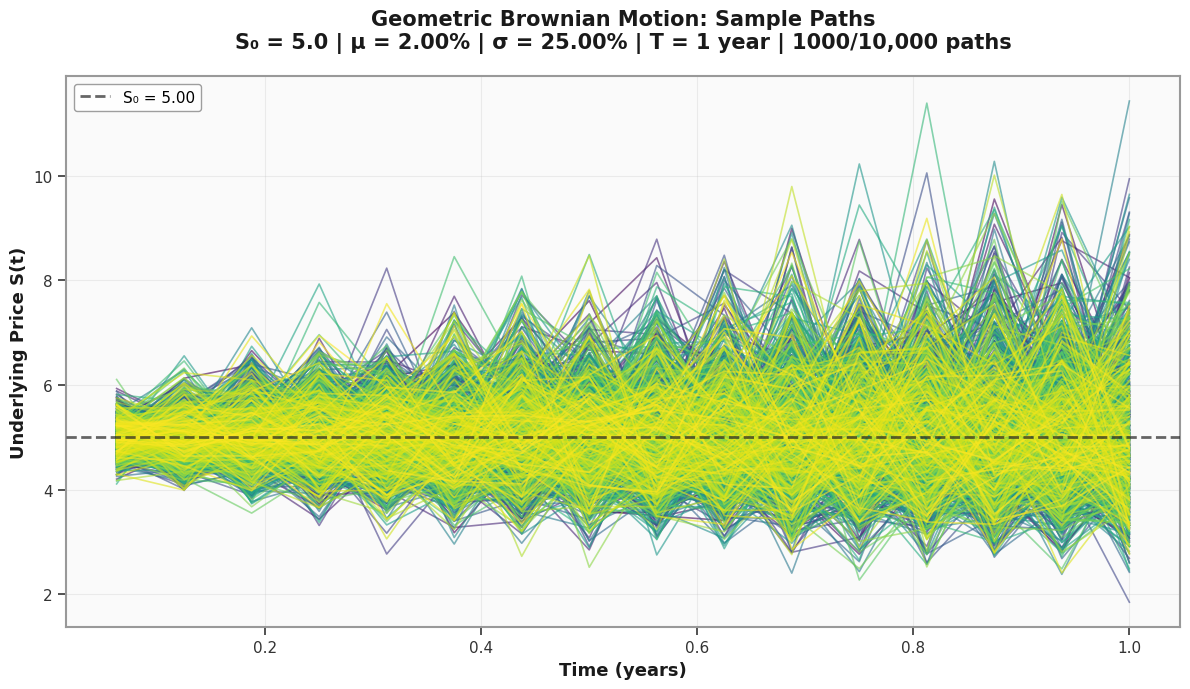

In [19]:
fig, ax = plot_GBM_dynamics(
    S_by_time_hr, t_hr, S0, r, sigma, T, n_paths_hr, n_plot=1000
)
plt.show()

In [20]:
# ============================================================
# Discretize prices with 64 bins (n=6)
# ============================================================
n_sigma_hr = 3.0

edges_hr, s_mid_hr = price_grid_from_samples(S_by_time_hr, n=n_hr, n_sigma=n_sigma_hr)

print(f"edges length: {len(edges_hr)} => N bins: {len(edges_hr) - 1}")
assert (len(edges_hr) - 1) == N_hr

# Build grid_info dictionary with s_mid for plotting
grid_info_hr = {'s_mid': s_mid_hr}
print(f"Grid info (high-resolution): {grid_info_hr}")
print(f"Bin centers (s_mid) range: [{s_mid_hr[0]:.3f}, {s_mid_hr[-1]:.3f}]")
print(f"Number of bin centers: {len(s_mid_hr)}")

edges length: 65 => N bins: 64
Grid info (high-resolution): {'s_mid': array([1.26835902, 1.38970445, 1.51104988, 1.6323953 , 1.75374073,
       1.87508616, 1.99643159, 2.11777701, 2.23912244, 2.36046787,
       2.4818133 , 2.60315872, 2.72450415, 2.84584958, 2.96719501,
       3.08854044, 3.20988586, 3.33123129, 3.45257672, 3.57392215,
       3.69526757, 3.816613  , 3.93795843, 4.05930386, 4.18064928,
       4.30199471, 4.42334014, 4.54468557, 4.66603099, 4.78737642,
       4.90872185, 5.03006728, 5.15141271, 5.27275813, 5.39410356,
       5.51544899, 5.63679442, 5.75813984, 5.87948527, 6.0008307 ,
       6.12217613, 6.24352155, 6.36486698, 6.48621241, 6.60755784,
       6.72890326, 6.85024869, 6.97159412, 7.09293955, 7.21428498,
       7.3356304 , 7.45697583, 7.57832126, 7.69966669, 7.82101211,
       7.94235754, 8.06370297, 8.1850484 , 8.30639382, 8.42773925,
       8.54908468, 8.67043011, 8.79177553, 8.91312096])}
Bin centers (s_mid) range: [1.268, 8.913]
Number of bin centers: 64


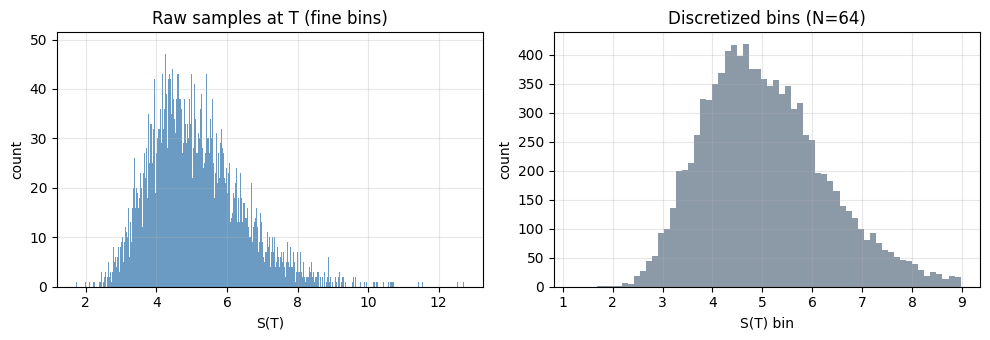

In [21]:
# ============================================================
# Histogram comparison: raw vs discretized (at final time)
# ============================================================
samples_hr_final = S_by_time_hr[-1]
fig, axes = plot_histogram_comparison(samples_hr_final, edges_hr)
plt.show()

In [22]:
# ============================================================
# Build conditional distributions P_bin[i,:] = P(s_bin | t_i)
# ============================================================
P_bin_hr = np.zeros((M_hr, N_hr), dtype=float)
for i in range(M_hr):
    P_bin_hr[i, :] = discrete_probs_from_samples(S_by_time_hr[i], edges_hr)

assert P_bin_hr.shape == (M_hr, N_hr)
assert np.all(P_bin_hr >= -1e-15)
assert np.allclose(P_bin_hr.sum(axis=1), 1.0, atol=1e-10)

print(f"P_bin_hr OK. shape: {P_bin_hr.shape}")
print(f"Represents conditional distributions P(s|t) for M={M_hr} time steps and N={N_hr} price bins")

P_bin_hr OK. shape: (16, 64)
Represents conditional distributions P(s|t) for M=16 time steps and N=64 price bins


In [23]:
# ============================================================
# Build joint target distribution for the full time-price space
# ============================================================
tgt_hr = build_joint_target_from_P_bin(P_bin_hr, order="time_major")

print("\n--- Joint target summary (high-resolution) ---")
print(f"M={tgt_hr.M} (m={tgt_hr.m} qubits), N={tgt_hr.N} (n={tgt_hr.n} qubits)")
print(f"Total qubits: {tgt_hr.m + tgt_hr.n}")
print(f"len(p_tg) = {tgt_hr.p_tg.size} (expected M*N = {tgt_hr.M * tgt_hr.N})")
print(f"sum(p_tg) = {tgt_hr.p_tg.sum():.15f}")

assert tgt_hr.M == M_hr
assert tgt_hr.N == N_hr
assert tgt_hr.p_tg.ndim == 1
assert tgt_hr.p_tg.size == M_hr * N_hr
assert abs(tgt_hr.p_tg.sum() - 1.0) < 1e-12


--- Joint target summary (high-resolution) ---
M=16 (m=4 qubits), N=64 (n=6 qubits)
Total qubits: 10
len(p_tg) = 1024 (expected M*N = 1024)
sum(p_tg) = 1.000000000000000


### Extract Last Time Step for Single Time QCBM

Now we extract only the probability distribution at the final time step $t = T$ from the high-resolution simulation. This marginal distribution will be used to train a QCBM without temporal dimension.

In [24]:
# ============================================================
# Extract final time step distribution
# ============================================================
# From P_bin_hr, the last row contains P(s | t_final)
ptg_single = P_bin_hr[-1, :].copy()

# Alternatively, compute directly from samples (equiv, sanity check)
ptg_single_check = discrete_probs_from_samples(S_by_time_hr[-1], edges_hr)

print("Extracted single time step distribution:")
print(f"Shape: {ptg_single.shape}")
print(f"N = {N_hr} bins ({n_hr} qubits)")
print(f"sum(ptg_single) = {ptg_single.sum():.15f}")
print(f"\nVerification (direct from samples):")
print(f"Max difference: {np.max(np.abs(ptg_single - ptg_single_check)):.2e}")

assert ptg_single.shape == (N_hr,)
assert np.isclose(ptg_single.sum(), 1.0)

# Use the extracted distribution for training
n_single = n_hr
N_single = N_hr
edges_single = edges_hr

Extracted single time step distribution:
Shape: (64,)
N = 64 bins (6 qubits)
sum(ptg_single) = 1.000000000000000

Verification (direct from samples):
Max difference: 0.00e+00


In [25]:
# ============================================================
# QCBM ansatz for single time (6 qubits)
# ============================================================
num_qubits_single = n_single  # 6 qubits for price

qcbm_single = MLQcbmCircuit(n_qubits=num_qubits_single, n_layers=8, name="G_p_single")
qc_single, theta_single = qcbm_single.qc, qcbm_single.theta

print(qc_single.draw(output="text", fold=120))
print("n_layers:", qcbm_single.n_layers)
print("n_params:", qcbm_single.n_params)

      ┌──────────────┐ ┌──────────────┐┌─────────────────┐┌─────────────────┐┌─────────────────┐                   »
q_0: ─┤ Rx(theta[0]) ├─┤ Rz(theta[1]) ├┤0                ├┤0                ├┤0                ├───────────────────»
      ├──────────────┤ ├──────────────┤│  Rxx(theta[12]) ││                 ││                 │┌─────────────────┐»
q_1: ─┤ Rx(theta[2]) ├─┤ Rz(theta[3]) ├┤1                ├┤  Rxx(theta[13]) ├┤                 ├┤0                ├»
      ├──────────────┤ ├──────────────┤└─────────────────┘│                 ││  Rxx(theta[14]) ││  Rxx(theta[17]) │»
q_2: ─┤ Rx(theta[4]) ├─┤ Rz(theta[5]) ├───────────────────┤1                ├┤                 ├┤1                ├»
      ├──────────────┤ ├──────────────┤                   └─────────────────┘│                 │└─────────────────┘»
q_3: ─┤ Rx(theta[6]) ├─┤ Rz(theta[7]) ├──────────────────────────────────────┤1                ├───────────────────»
      ├──────────────┤ ├──────────────┤                         

### Training (statevector mode)

In [26]:
# ============================================================
# Hyperparameters for single time training
# ============================================================
SEED_SINGLE = 123
N_ITERS_SINGLE = 20000
RHOBEG_SINGLE = 0.05
METHOD_SINGLE = "COBYLA"
EPS_COST_SINGLE = 1e-9

rng_single = np.random.default_rng(SEED_SINGLE)
x0_single = rng_single.standard_normal(len(theta_single)).astype(float)

In [27]:
# ============================================================
# Define cost function and run optimization
# ============================================================
cost_single = qcbm_single.cost_fn(ptg_single, eps=EPS_COST_SINGLE)

res_single, cost_history_single = minimize_with_cost_history(
    cost_single,
    x0=x0_single,
    minimize_fn=minimize,
    method=METHOD_SINGLE,
    options={"maxiter": int(N_ITERS_SINGLE), 
             "rhobeg": RHOBEG_SINGLE,
             "disp": True},
)

theta_star_single = np.asarray(res_single.x, dtype=float)

# Probabilities before and after training
p0_single = qcbm_single.probabilities(x0_single)
p_star_single = qcbm_single.probabilities(theta_star_single)

print("success:", res_single.success)
print("message:", res_single.message)
print("nfev:", getattr(res_single, "nfev", None), "nit:", getattr(res_single, "nit", None))
print("final cost:", float(res_single.fun))

success: False
message: Maximum number of function evaluations has been exceeded.
nfev: 20000 nit: None
final cost: 3.6924773575339738


In [28]:
# ============================================================
# Metrics and results
# ============================================================
ms_single = qcbm_single.metrics(ptg_single, p_star_single)

print("\n=== TRAINING RESULTS (Single Time) ===")
print("KL(ptg || p*)  =", float(ms_single["kl"]))
print("L1             =", float(ms_single["l1"]))
print("TV = 0.5*L1    =", float(ms_single["tv"]))
print("Linf           =", float(ms_single["linf"]))

print("\n=== PROBABILITY VECTORS ===")
print("Target (ptg_single):")
print(ptg_single)
print("\nLearned (p_star_single):")
print(p_star_single)


=== TRAINING RESULTS (Single Time) ===
KL(ptg || p*)  = 2.9559929487870643e-07
L1             = 0.0004910211531493039
TV = 0.5*L1    = 0.00024551057657465195
Linf           = 4.707999096484339e-05

=== PROBABILITY VECTORS ===
Target (ptg_single):
[0.         0.         0.         0.         0.00010086 0.00010086
 0.00010086 0.00020171 0.00060514 0.00040343 0.00191629 0.00272315
 0.00443772 0.00534544 0.00937973 0.01008573 0.01371659 0.0200706
 0.02027231 0.0214826  0.02632375 0.03267776 0.03247605 0.03530005
 0.03711548 0.04104892 0.04205749 0.0401412  0.04215835 0.03782148
 0.03782148 0.03610691 0.03499748 0.03600605 0.03348462 0.03499748
 0.03086233 0.03197176 0.02632375 0.02551689 0.01976803 0.01956631
 0.01845688 0.01664145 0.01401916 0.0132123  0.01190116 0.01008573
 0.00816944 0.00927887 0.0075643  0.00635401 0.00605144 0.00514372
 0.00463944 0.00453858 0.00403429 0.002824   0.00191629 0.00252143
 0.00221886 0.001412   0.00191629 0.00161372]

Learned (p_star_single):
[1.81514867

In [29]:
# ============================================================
# Prepare data for plotting
# ============================================================
C_star_single = -np.sum(ptg_single * np.log(np.maximum(ptg_single, EPS_COST_SINGLE)))
rescaled_single = cost_history_single - C_star_single
rescaled_plot_single = np.maximum(rescaled_single, 1e-12)
best_so_far_single = np.minimum.accumulate(rescaled_plot_single)

tol_single = 1e-15
best_idx_single = np.flatnonzero(np.r_[True, best_so_far_single[1:] < best_so_far_single[:-1] - tol_single])

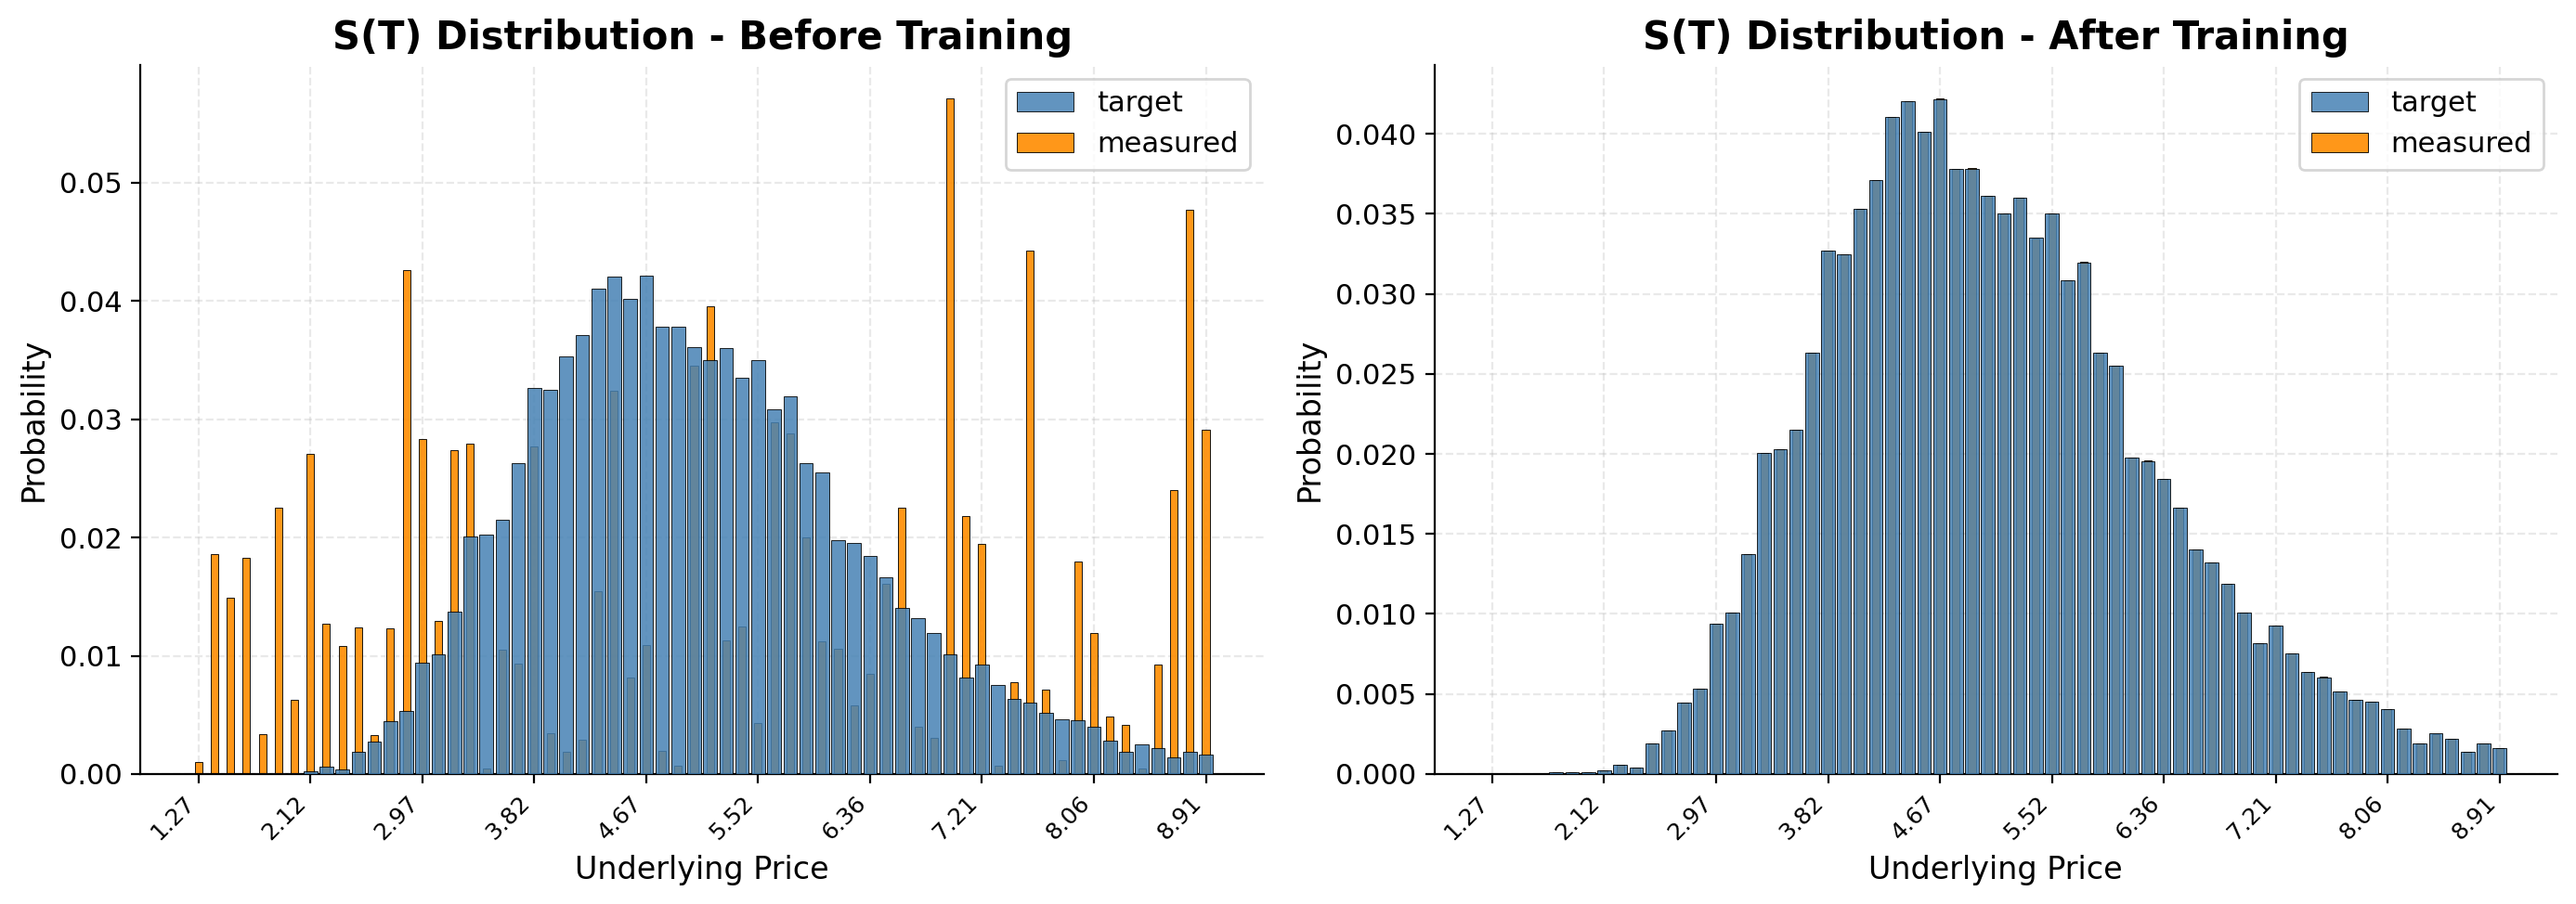

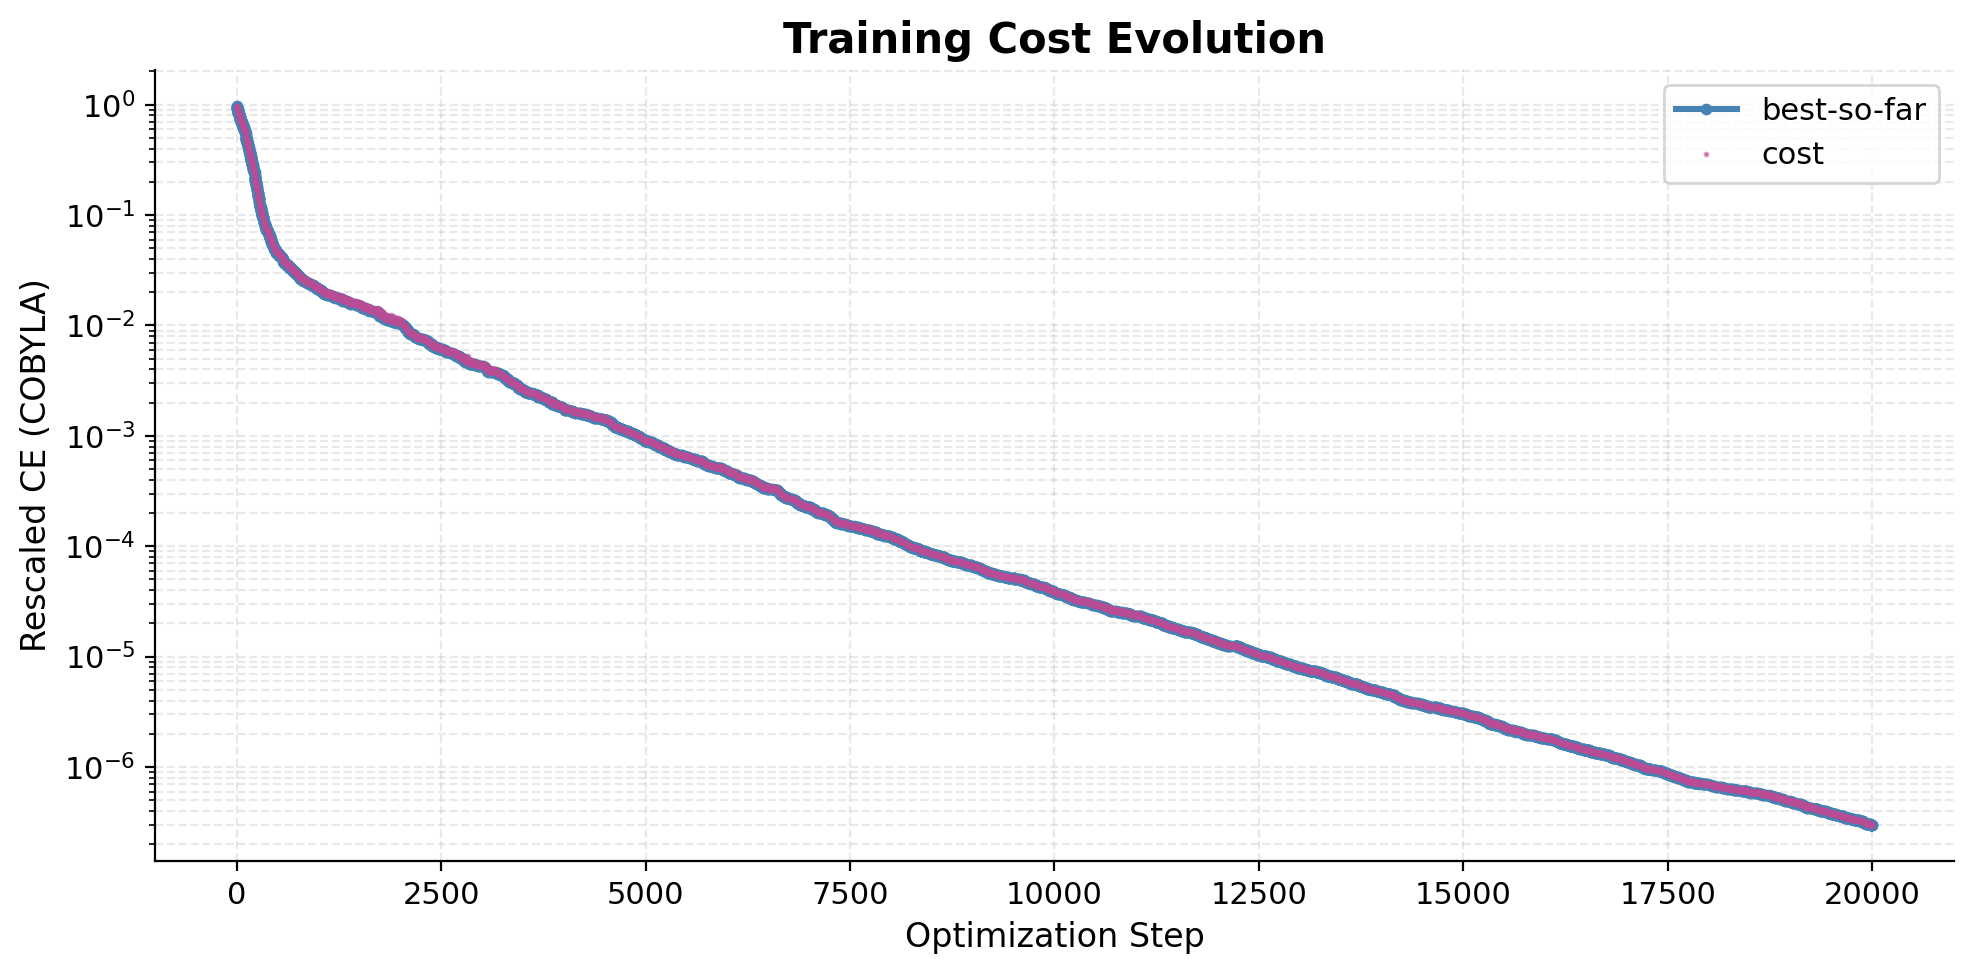

In [31]:
# ============================================================
# Visualize training results
# ============================================================
fig_dist_single, fig_cost_single = plot_training_diagnostics(
    target=ptg_single,
    before=p0_single,
    after=p_star_single,
    cost_history=rescaled_plot_single,
    best_so_far=best_so_far_single,
    best_idx=best_idx_single,
    grid_info=grid_info_hr,  
    cost_ylabel=f"Rescaled CE (COBYLA)",
)
plt.show()